In [1]:
from transformers import BertModel, BertTokenizer
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import torch
import plotly.express as px

In [2]:
# pip install -U voyageai

In [2]:
from google.colab import files
uploaded = files.upload()
# titles = pd.read_csv("../data/nes_titles.csv")['Title']
titles = pd.read_csv("./nes_titles.csv")['Title']

Saving nes_titles.csv to nes_titles (1).csv


In [3]:
titles.head()

0                            '89 Dennou Kyuusei Uranai
1                                        10-Yard Fight
2                                                 1942
3    1943: The Battle of Midway 1943: The Battle of...
4                  1999: Hore Mita Koto Ka! Seikimatsu
Name: Title, dtype: object

In [5]:
word_to_index = {}
index_to_word = {}
for title in titles:
    for word in title.split():
        if word not in word_to_index:
            index = len(word_to_index)
            word_to_index[word] = index
            index_to_word[index] = word
words = list(word_to_index.keys())

### Create Embedding from Alibaba NLP

In [6]:
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer


In [7]:
model_path = 'Alibaba-NLP/gte-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# batch_dict = tokenizer(words, max_length=8192, padding=True, truncation=True, return_tensors='pt')
# outputs = model(**batch_dict)
# embeddings = outputs.last_hidden_state[:, 0]

In [8]:
word_embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    word_embeddings.append(embeddings)

word_embeddings = np.array(word_embeddings)

In [11]:
word_embeddings.shape

(2710, 768)

In [13]:
with open('./gte_base_embeddings.npy', 'wb') as f:
    np.save(f, word_embeddings)

In [178]:
# import voyageai

# vo = voyageai.Client(api_key='pa-cpmHP1-2ed1TWbTxU_zTa9oPsjc5Ll5qrw-MPfRhspA')
# word_chunks = [words[i:i+128] for i in range(0, len(words), 128)]
# print(len(words_chunks[0]))
# print(len(words_chunks[-2]))
# print(len(words_chunks[-1]))
# # prompt: set up a for loop for word_chunk in word_chunks that uses embed and sleep timer for 3 calls per minute - evenly space out the calls with sleep timer
# import time
# final_result = []

# counter = 1
# for word_chunk in word_chunks:
#   if counter % 3 == 0:
#     time.sleep(60)
#   counter += 1
#   result = vo.embed(word_chunk, model="voyage-large-2-instruct")
#   final_result.extend(result.embeddings)


### Create Embedding from BERT Tokenizer

In [ ]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

/Users/bradleywise/Envs/nes_salad/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [ ]:
# Select words you want to visualize
# words = ['king', 'queen', 'man', 'woman', 'doctor', 'nurse']
# words = list(word_to_index.keys())

# Extract word embeddings
word_embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    word_embeddings.append(embeddings)

word_embeddings = np.array(word_embeddings)

In [ ]:
word_embeddings.shape

(2710, 768)

In [ ]:
with open('../data/BERT_embeddings.npy', 'wb') as f:
    np.save(f, word_embeddings)

### Visualize Data in 3D

In [14]:
from google.colab import files
uploaded = files.upload()
# word_embeddings = np.load('../data/BERT_embeddings.npy')
word_embeddings = np.load('./gte_base_embeddings.npy')
word_embeddings.shape

Saving gte_base_embeddings.npy to gte_base_embeddings (1).npy


(2710, 768)

In [15]:
# Reduce dimensionality to 3D using t-SNE
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)
word_embeddings_3d.shape

(2710, 3)

In [16]:
shuffled_indices = np.random.permutation(len(words))
num_rows_to_sample = 500

# Take the first 500 shuffled indices to get the sampled rows and words
sampled_rows = word_embeddings_3d[shuffled_indices[:num_rows_to_sample]]
sampled_words = [words[i] for i in shuffled_indices[:num_rows_to_sample]]

In [17]:
print(word_embeddings_3d.shape)
print(sampled_rows.shape)

(2710, 3)
(500, 3)


In [18]:
fig = px.scatter_3d(x=sampled_rows[:, 0], y=sampled_rows[:, 1],
                    z=sampled_rows[:, 2], text=sampled_words)
fig.show()

### Use DB Scan to give each set of words a relationship to each other in 3d Space
- might make it easier to visualize
- https://stackoverflow.com/questions/43160240/how-to-plot-a-k-distance-graph-in-python

In [19]:
import matplotlib.pyplot as plt

In [20]:
word_embeddings_3d[0]
np.linalg.norm(word_embeddings_3d[0], 2)

37.80962

In [40]:
# def cosine_similarity(vector1, vector2):
#     """
#     Compute cosine similarity between two vectors.

#     Parameters:
#     vector1 (numpy.ndarray): First vector.
#     vector2 (numpy.ndarray): Second vector.

#     Returns:
#     float: Cosine similarity between the two vectors.
#     """
#     dot_product = np.dot(vector1, vector2)
#     norm_vector1 = np.linalg.norm(vector1, 2) # use l2 norm
#     norm_vector2 = np.linalg.norm(vector2, 2) # use l2 norm
#     similarity = dot_product / (norm_vector1 * norm_vector2)
#     return similarity
# def cosine_similarity_matrix(data):
#     """
#     Compute cosine similarity matrix for a dataset.

#     Parameters:
#     data (numpy.ndarray): Dataset where each row represents a data point.

#     Returns:
#     numpy.ndarray: Cosine similarity matrix.
#     """
#     num_samples = len(data)
#     similarity_matrix = np.zeros((num_samples, num_samples))

#     for i in range(num_samples):
#         for j in range(num_samples):
#             similarity_matrix[i, j] = 1 - cosine_similarity(data[i], data[j]) # distance measure

#     return similarity_matrix
# distance = cosine_similarity_matrix(word_embeddings_3d)

In [21]:
def calculate_kn_distance(X, k):
    kn_distance = []
    for i in range(len(X)):
        cosine_similarities = []
        for j in range(len(X)):
            if i != j:  # Skip computing similarity with itself
                cosine_similarities.append(np.dot(X[i], X[j]) / (np.linalg.norm(X[i], 2) * np.linalg.norm(X[j], 2))) # use l2 norm

        cosine_similarities.sort(reverse=True)
        kn_distance.append(1 - cosine_similarities[k-1])  # k-1 to get k-th nearest neighbor (0-indexed)

    return kn_distance

In [22]:
eps_dist = calculate_kn_distance(word_embeddings_3d, 20)
print(np.mean(eps_dist))
print(np.median(eps_dist))

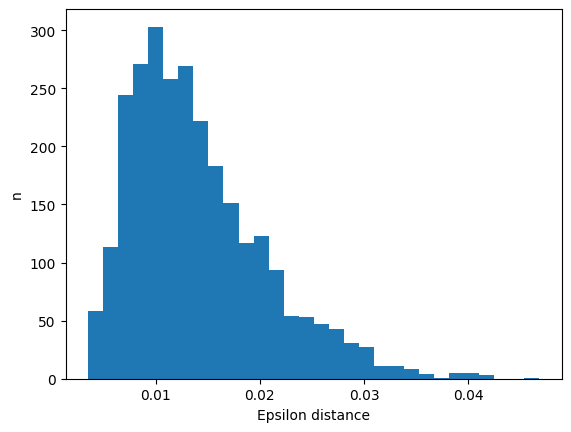

In [24]:
plt.hist(eps_dist,bins=30)
plt.ylabel('n');
plt.xlabel('Epsilon distance');

In [25]:
from sklearn.cluster import DBSCAN

In [26]:
word_embeddings_3d.shape

(2710, 3)

In [27]:
clustering = DBSCAN(eps=0.01, min_samples=20, metric='cosine').fit(word_embeddings_3d)

In [28]:
pd.DataFrame(clustering.labels_, columns=['label'])['label'].value_counts()

label
-1     709
 1     614
 3     299
 5     125
 14    122
 16     79
 0      67
 10     61
 4      60
 17     50
 7      48
 12     46
 2      45
 15     40
 8      36
 9      35
 21     30
 13     30
 6      29
 19     29
 11     27
 20     23
 18     21
 25     21
 23     20
 24     17
 22     15
 26     12
Name: count, dtype: int64

In [29]:
clustering.labels_

array([ 0, -1,  1, ..., -1,  1, -1])

In [34]:
shuffled_indices = np.random.permutation(len(words))
num_rows_to_sample = 2710

# Take the first N shuffled indices to get the sampled rows and words
sampled_rows = word_embeddings_3d[shuffled_indices[:num_rows_to_sample]]
sampled_words = [words[i] for i in shuffled_indices[:num_rows_to_sample]]
sampled_labels = [clustering.labels_[i] for i in shuffled_indices[:num_rows_to_sample]]

In [35]:
fig = px.scatter_3d(x=sampled_rows[:, 0], y=sampled_rows[:, 1],
                    z=sampled_rows[:, 2], text=sampled_words, color=sampled_labels)
fig.show()

In [ ]:
# import plotly.graph_objects as go

# # Assuming word_embeddings_3d is a numpy array containing your word embeddings
# # and words is a list of corresponding words

# # Create 3D scatter plot
# fig = go.Figure(data=[go.Scatter3d(
#     x=word_embeddings_3d[:, 0],
#     y=word_embeddings_3d[:, 1],
#     z=word_embeddings_3d[:, 2],
#     mode='markers',
#     marker=dict(
#         size=8,
#         color='rgb(0,0,255)',  # Change color if needed
#     ),
#     text=words,  # Assign words as text
# )])

# # Add annotations
# annotations = []
# for i, word in enumerate(words):
#     annotation = dict(
#         x=word_embeddings_3d[i, 0],
#         y=word_embeddings_3d[i, 1],
#         z=word_embeddings_3d[i, 2],
#         text=word,
#         showarrow=False,
#         font=dict(
#             color='black',  # Adjust font color if needed
#             size=12,
#         ),
#     )
#     annotations.append(annotation)

# fig.update_layout(
#     scene=dict(
#         annotations=annotations,
#     ),
# )

# fig.show()


## 2D Representation

In [36]:
# Reduce dimensionality to 3D using t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)
word_embeddings_3d.shape

(2710, 2)

In [41]:
shuffled_indices = np.random.permutation(len(words))
num_rows_to_sample = 2710

# Take the first 500 shuffled indices to get the sampled rows and words
sampled_rows = word_embeddings_3d[shuffled_indices[:num_rows_to_sample]]
sampled_words = [words[i] for i in shuffled_indices[:num_rows_to_sample]]

In [42]:
print(word_embeddings_3d.shape)
print(sampled_rows.shape)

(2710, 2)
(2710, 2)


In [44]:
fig = px.scatter(x=sampled_rows[:, 0], y=sampled_rows[:, 1], text=sampled_words)
fig.update_traces(textfont=dict(size=8))  # Change the size as needed
fig.show()

In [45]:
eps_dist = calculate_kn_distance(word_embeddings_3d, 20)
print(np.mean(eps_dist))
print(np.median(eps_dist))

0.00030596161680467894
0.00022414326667785645


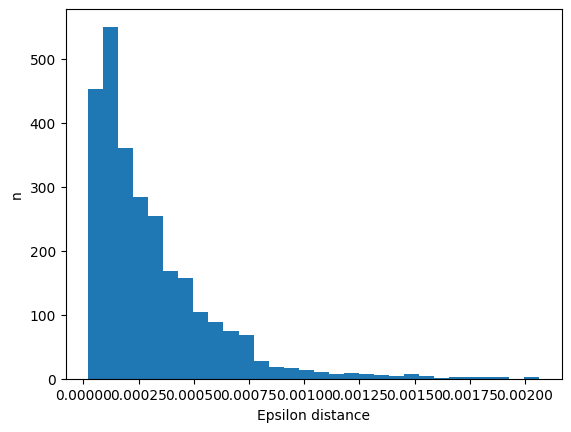

In [46]:
plt.hist(eps_dist,bins=30)
plt.ylabel('n');
plt.xlabel('Epsilon distance');

In [47]:
clustering = DBSCAN(eps=0.0002, min_samples=20, metric='cosine').fit(word_embeddings_3d)
pd.DataFrame(clustering.labels_, columns=['label'])['label'].value_counts()

label
-1     883
 1     504
 2     347
 6      75
 8      61
 15     61
 3      51
 20     46
 14     45
 18     44
 5      44
 19     42
 0      42
 12     40
 13     40
 16     38
 4      36
 7      32
 21     32
 9      32
 10     29
 24     25
 27     25
 17     22
 22     21
 23     21
 28     20
 11     20
 25     20
 26     12
Name: count, dtype: int64

In [51]:
shuffled_indices = np.random.permutation(len(words))
num_rows_to_sample = 500

# Take the first N shuffled indices to get the sampled rows and words
sampled_rows = word_embeddings_3d[shuffled_indices[:num_rows_to_sample]]
sampled_words = [words[i] for i in shuffled_indices[:num_rows_to_sample]]
sampled_labels = [clustering.labels_[i] for i in shuffled_indices[:num_rows_to_sample]]

In [54]:
fig = px.scatter(x=sampled_rows[:, 0], y=sampled_rows[:, 1], text=sampled_words, color=sampled_labels)
fig.update_traces(textfont=dict(size=10))  # Change the size as needed
fig.show()